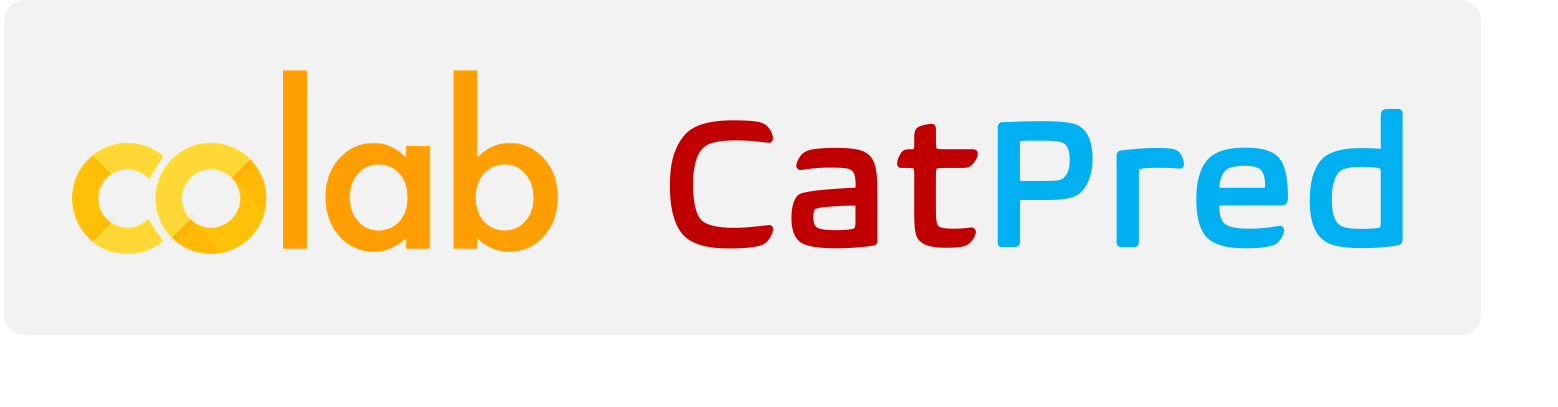


# CatPred: 효소-기질 $k_{cat}$, $K_{m}$ 과 효소-억제제 $K_{i}$ 예측

**설명**
- 이 노트북은 효소 동역학 파라미터 예측을 위해 CatPred 모델을 실행합니다.

- 파이프라인은 효소 서열을 ESM2 언어 모델 인코딩으로, 반응물 SMILES 문자열을 2D 그래프로 처리하여 사전 학습된 CatPred 모델에 입력합니다.

- CatPred의 출력은 첨부된 예측 불확실성과 함께 운동 파라미터 예측입니다.

- 기본적으로 노트북은 예제 효소 서열과 기질에서 실행되며, 각 셀의 왼쪽에 있는 ▶ 아이콘을 클릭하여 각 셀을 사용자 입력에 맞게 편집하고 “실행”합니다.

<br>


**입력**
1. 효소 서열 - 효소의 아미노산 서열(대문자 표시 및 공백 제거)
2. 기질/억제제 표준 SMILES 문자열 $K_{m}$ 와 $K_{i}$ 또는 $k_{cat}$의 모든 반응물의 합쳐진 SMILES 문자열. (`.`을 기준으로 연결)

<br>

**출력**

- $k_{cat}$ 또는 $K_{m}$ 또는 $K_{i}$ 예측값과 예상 표준 편차

<br>

**기타**

자세한 정보는 다음 링크 참조 : https://github.com/maranasgroup/catpred/


---

# CatPred 설치 및 환경 설정

In [3]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2024.10-1-Linux-x86_64.sh #아나콘다 설치
!chmod +x Anaconda3-2024.10-1-Linux-x86_64.sh #아나콘다 권한 허용
!bash ./Anaconda3-2024.10-1-Linux-x86_64.sh -b -f -p /usr/local #아나콘다 실행

!wget https://catpred.s3.us-east-1.amazonaws.com/pretrained_production.tar.gz -q #catpred 다운로드
!tar -xzf pretrained_production.tar.gz #압축 해제
!wget https://catpred.s3.amazonaws.com/processed_databases.tar.gz -q #catpred 전처리 db 압축파일 다운로드
!tar -xzf processed_databases.tar.gz #압축 해제

!git clone https://github.com/maranasgroup/catpred.git && cd catpred && git checkout 9d57732 #git clone

#디렉터리(폴더) 이동
%cd catpred/
!conda env create -f ./environment.yml -q #아나콘다 가상환경 생성
!source activate catpred;pip install -e . -q #아나콘다 가상환경 실행 및 pip 설치
!chmod +x predict.sh #predict.sh 파일 실행 권한 허용

import sys
sys.path.append('/usr/local/envs/catpred/lib/python3.9/site-packages') #환경 변수 설정

--2025-07-09 10:32:21--  https://repo.anaconda.com/archive/Anaconda3-2024.10-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102495056 (1.0G) [application/octet-stream]
Saving to: ‘Anaconda3-2024.10-1-Linux-x86_64.sh’

    Anaconda3-2024.  70%[=============>      ] 745.40M  81.2MB/s    eta 5s     ^C
PREFIX=/usr/local
expected: da0708a27f2d34e05c04714b640b104f
     got: 3b9309d532eb34f63180acc96f6e0416  -
Unpacking payload ...
object address  : 0x78120c6bfe20
object refcount : 2
object type     : 0x78120e21c7e0
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
lost sys.stderr
[6552] Failed to execute script 'entry_point' due to unhandled exception!
^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archiv

---

# BRANDA 데이터 로드 및 전처리

## 1. 전처리 함수 정의

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem #분자식 라이브러리
from google.colab import data_table #빅쿼리 테이블 import
data_table.enable_dataframe_formatter() #테이블 포맷 불러오기

#rdkit 로깅 비활성화
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

#wrapper 사용한 함수 확장 정의
def run_once(func):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.result = func(*args, **kwargs)
            wrapper.has_run = True
        return wrapper.result
    wrapper.has_run = False
    return wrapper

#run_once 함수 실행
@run_once

#brenda_data 읽기 (brenda db는 효소 db)
#input은 데이터 파일 경로(문자열)을 dataframe으로 변경
def load_brenda_data(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)

#reaction SMILES 전처리 함수
#rdkit(분자식) 형태 리턴
#PRSC
def preprocess_reaction_smiles(reaction_smiles: str) -> str:
    if not pd.isna(reaction_smiles): #reaction_smiles에 결측값이 없으면 실행
        reactants = reaction_smiles.split('>>')[0] ## >> 기준 분할 및 첫 번째 저장
        if '.' in reactants: #만약 첫 번째 단어 안에 .이 존재하면
            reactant_list = reactants.split('.') #.을 기준으로 분할해서 리스트 저장
            reactant_list = sorted(reactant_list) #문자열 순 정렬
            canonicalized_reactants = [] #리스트 생성
            for reactant in reactant_list: #.이 있을 때 리스트 속 모든 문자열 반복 실행
                try:
                    mol = Chem.MolFromSmiles(reactant) #리스트 속 문자열을 분자식 변경하고 이를 그림으로 변경하여 mol에 저장
                    canonicalized_reactants.append(Chem.MolToSmiles(mol, isomericSmiles=False)) #그림으로 표현된 분자식을 문자식으로 변경하고 이를 list에 추가
                except: #예외처리
                    canonicalized_reactants.append(reactant) #예외 생기면 바로 리스트에 추가
            reactants = '.'.join(canonicalized_reactants) #리스트 속 문자열을 공백없이 합치기
        return reactants #최종 합친 문자열 리턴
    else:
        return 'None' #. 존재 하지 않으면 None 리턴

#run_once 함수 실행
@run_once


#kcat 및 kmki 예측하기 위한 입력 데이터 전처리
def create_input_strings_brenda(brenda_df: pd.DataFrame) -> pd.DataFrame:
    brenda_df['reactant_smiles'] = brenda_df['reaction_smiles'].apply(preprocess_reaction_smiles) #rectant_smiles 열은 reaction_smiles를 분자식 형태로 전처리한 값 (preprocess_reaction_smiles 함수 사용)
    brenda_df['input_str_kcat'] = brenda_df['sequence'] + np.array(['__']*len(brenda_df)) + brenda_df['reactant_smiles'] #input_str_kcat 열은 {sequnce__reactant_smiles}
    brenda_df['input_str_kmki'] = brenda_df['sequence'] + np.array(['__']*len(brenda_df)) + brenda_df['substrate_smiles'] #input_str_kmki 열은 {sequence__substrate_smiles}
    return brenda_df #데이터 프레임 리턴

#데이터프레임에서 찾는 함수
#brenda_df는 데이터 프레임
#input_smi는 smiles 문자열
#seq는 sequence
#parameter는 kcat, km, ki 중 하나
def find_matches_brenda(brenda_df: pd.DataFrame, input_smi: str, seq: str, parameter: str) -> pd.DataFrame:
    input_smi = preprocess_reaction_smiles(input_smi) #input_smi 문자열을 분자식 형태로 전처리 (preprocess_reaction_smiles 함수 사용)
    input_str = seq + '__' + input_smi #input_str은 {seq값__input_smi값}
    if parameter == 'kcat': #만약 prameter 값이 kcat일 때
      input_header = 'input_str_kcat'
      label_header = 'turnover_number'
    elif parameter == 'km': #prameter 값이 km 일 때
      input_header = 'input_str_kmki'
      label_header = 'km_value'
    else: #prameter 값이 ki일 때
      input_header = 'input_str_kmki'
      label_header = 'ki_value'

    matched = brenda_df[brenda_df[input_header] == input_str] #matched 값은 인 풋 헤더 값이 Input str인 열
    matched_values = matched[matched['parameter'] == label_header] #matched_values는 Matched 열 중에서 파라미터가 라벨 헤더 인 거
    return matched_values #matched_values 리턴

#matched_values 중에서 seq 맞는 거 찾기 함수
#brenda_df는 데이터 프레임
#seq는 sequence
def find_matches_brenda_seq(brenda_df: pd.DataFrame, seq: str) -> pd.DataFrame:
    input_str = seq #input_str에 입력받은 seq 저장
    label_header = 'turnover_number' #라벨 헤더 지정
    matched = brenda_df[brenda_df['sequence'] == input_str] #데이터 프레임 중 sequnce가 입력으로 받은 input_str인 것들만 Matched에 저장
    matched_values = matched[matched['parameter'] == label_header] #Matched 중에서 parameter가 turnover_number인 것들만 matched_values에 저장
    return matched_values #리턴

#일치하는 애들 출력
#matched_values는 find_matches_brenda_seq 함수 리턴 값
#parameter는 kcat, km, ki 중 하나
def display_matches_brenda(matched_values: pd.DataFrame, parameter: str) -> None:
    display_cols_brenda = ['organism', 'ec', 'substrate', 'parameter', 'value', 'ph', 'temperature', 'comment'] #출력 열 지정
    if parameter.lower() == 'kcat': #만약 parameter가 kcat이면
        display_cols_brenda.append('reaction_smiles') #출력 열에 'reaction_smiles' 추가
    elif parameter.lower() == 'km' or parameter.lower() == 'ki':
        display_cols_brenda.append('substrate_smiles') #아니면 출력 열에 'substrate_smiles'cnrk

    print(f'BRENDA에서 {len(matched_values)}를 발견했습니다: ')
    if len(matched_values) > 0: #만약 1개라도 검색 결과가 있으면
        display(matched_values[display_cols_brenda]) #검색 결과 출력 (단, 위에서 지정한 열들만)

## 2. 데이터 로드 및 실행

In [ ]:
#brenda 데이터 (DB) 가져오기
brenda_df = load_brenda_data('../processed_databases/brenda.csv')

# 인풋 문자열 만들기
# brenda 데이터를 함수 통해서 전처리 진행
brenda_df = create_input_strings_brenda(brenda_df)

---

# SABIO-RK 데이터 로드 및 전처리

## 1. 전처리 함수 정의

In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem #분자식 라이브러리
from google.colab import data_table #빅쿼리 테이블 import
data_table.enable_dataframe_formatter() #테이블 포맷 불러오기

#wrapper 사용한 함수 확장 정의
def run_once(func):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.result = func(*args, **kwargs)
            wrapper.has_run = True
        return wrapper.result
    wrapper.has_run = False
    return wrapper

#run_once 함수 실행
@run_once

#sabio_data 읽기 (sabio-RK DB는 화학반응 db)
#input은 데이터 파일 경로(문자열)을 dataframe으로 변경
def load_sabio_data(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path, low_memory=False)

#run_once 함수 실행
@run_once

#Kcat와 kmki 예측을 위한 input 문자열 생성 함수
#입력으로 들어온 sabio-rk db 데이터를 입력 문자열로 변환하여 반환
def create_input_strings_sabio(sabio_df: pd.DataFrame) -> pd.DataFrame:
    sabio_df['reactant_smiles'] = sabio_df['reaction_smiles'].apply(preprocess_reaction_smiles) #'reactant_smiles' 의 값은 'preprocess_reaction_smiles' 함수 사용 (함수는 branda 함수 부분에 정의 되어 있으며 PRSC 단어 검색으로 이동 가능)
    sabio_df['input_str_kcat'] = sabio_df['sequence'] + np.array(['__']*len(sabio_df)) + sabio_df['reactant_smiles'] #input_str_kcat의 열은 {sequnce__reactant_smiles}
    sabio_df['input_str_kmki'] = sabio_df['sequence'] + np.array(['__']*len(sabio_df)) + sabio_df['param_species_smiles'] #input_str_kmki 열은 {sequence__substrate_smiles}
    return sabio_df #전처리 된 데이터 프레임 리턴

#데이터프레임에서 찾는 함수
#sabio_df 데이터 프레임
#input_smi는 smiles 문자열
#seq는 sequence
#parameter는 kcat, km, ki 중 하나
def find_matches_sabio(sabio_df: pd.DataFrame, input_smi: str, seq: str, parameter: str) -> pd.DataFrame:
    input_smi = preprocess_reaction_smiles(input_smi) #input_smi 문자열을 분자식 형태로 전처리 (preprocess_reaction_smiles 함수 사용 / 함수는 branda 함수 부분에 정의 되어 있으며 PRSC 단어 검색으로 이동 가능)
    input_str = seq + '__' + input_smi #input_str은 {seq값__input_smi값}

    if parameter == 'kcat': #만약 prameter 값이 kcat일 때
        input_header = 'input_str_kcat'
        label_header = 'kcat'
    elif parameter == 'km': #prameter 값이 km 일 때
         input_header = 'input_str_kmki'
         label_header = 'Km'
    else: #prameter 값이 ki일 때
        input_header = 'input_str_kmki'
        label_header = 'Ki'

    matched = sabio_df[sabio_df[input_header] == input_str] #matched 값은 인 풋 헤더 값이 Input str인 열
    matched_values = matched[matched['param_name'] == label_header] #matched_values는 Matched 열 중에서 param_name가 라벨 헤더 인 거
    return matched_values #matched_values 리턴

#일치하는 애들 출력
#matched_values는 find_matches_sabio 함수 리턴 값
#parameter는 kcat, km, ki 중 하나
def display_matches_sabio(matched_values: pd.DataFrame, parameter: str) -> None:
    display_cols_sabio = ['species', 'ec', 'param_species_name', 'param_name', 'param_value', 'ph', 'temperature', 'pubmed_id'] #출력 열 지정
    if parameter.lower() == 'kcat': #만약 parameter가 kcat이면
        display_cols_sabio.append('reaction_smiles')#출력 열에 'reaction_smiles' 추가
    elif parameter.lower() == 'km' or parameter.lower() == 'ki':
        display_cols_sabio.append('param_species_smiles')  #아니면 출력 열에 'substrate_smiles'cnrk

    print(f'SABIO-RK에서 {len(matched_values)} 를 발견했습니다:')
    if len(matched_values) > 0: #만약 1개라도 검색 결과가 있으면
        display(matched_values[display_cols_sabio]) #검색 결과 출력 (단, 위에서 지정한 열들만)

## 2. 데이터 로드 및 실행

In [ ]:
# 데이터 경로 지정 및 로드
sabio_df = load_sabio_data('../processed_databases/sabio.csv')

# input string 만들기
sabio_df = create_input_strings_sabio(sabio_df)

---
# 예측 관련 함수 정의

## 1. 예측을 위한 입력 CSV 및 셸 스크립트를 생성 함수 정의

In [7]:
# 예측을 위한 입력 CSV 및 셸 스크립트를 생성
# 예측 성공 시 효소 서열과 smiles 문자열
def create_csv_sh(parameter, uni, seq, smi):
    try:
        mol = Chem.MolFromSmiles(smi) #리스트 속 문자열을 분자식 변경하고 이를 그림으로 변경하여 mol에 저장
        smi = Chem.MolToSmiles(mol) #그림으로 표현된 분자식을 문자식으로 변경하고 이를 list에 추가

    except: #분자식 변경이 불가능할 때
        print('잘못된 SMILES 입니다.')
        print('..................')
        return None

    valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
    if not set(seq).issubset(valid_aas):
        print('잘못된 효소 sequence 입니다.')
        print('..................')
        return None

    # kcat 예측을 위한 SMILES 요소 정렬
    if parameter == 'kcat' and '.' in smi: #만약 prameter가 kcat이고 smi에 .이 있을 때
        smi = '.'.join(sorted(smi.split('.'))) #.을 기준으로 합치기

    # 입력 csv 만들기
    with open(f'{uni}_{parameter}_input.csv', 'w') as f:
        f.write('name,sequence,SMILES,pdbpath\n')
        f.write(f'{uni},{seq},{smi},{uni}.pdb\n')

    # 예측 파일(.sh) 쉘 스크립트 작성
    with open('predict.sh', 'w') as f:
        f.write(f'''
TEST_FILE_PREFIX={uni}_{parameter}
RECORDS_FILE=${{TEST_FILE_PREFIX}}.json.gz
CHECKPOINT_DIR=../pretrained/production/{parameter}/

python ./scripts/create_pdbrecords.py --data_file ${{TEST_FILE_PREFIX}}_input.csv --out_file ${{RECORDS_FILE}}
python predict.py --test_path ${{TEST_FILE_PREFIX}}_input.csv --preds_path ${{TEST_FILE_PREFIX}}_output.csv --checkpoint_dir $CHECKPOINT_DIR --uncertainty_method mve --smiles_column SMILES --individual_ensemble_predictions --protein_records_path $RECORDS_FILE
''')

    print('입력 파일 생성 성공')
    print('효소 서열 길이:', len(sequence))
    print('기질 구조:')
    display(ShowMols([mol]))

    return seq, smi

## 2. 예측 함수

In [8]:
# 예측 생성
# prameter는 예측된 값
# uniport_id 는 유니포트 값 또는 이름
def get_predictions(parameter, uniprot_id):

    # 해당 값으로 만들어진 데이터 파일 읽어 오기
    df = pd.read_csv(f'{uniprot_id}_{parameter}_output.csv')

    # 파라미터 별 target_col 설정
    if parameter == 'kcat':
        parameter_print, parameter_print_log = 'k_{cat}', 'log_{10}(k_{cat})'
        target_col, unit = 'log10kcat_max', ' s^{-1}'
    elif parameter == 'km':
        parameter_print, parameter_print_log = 'K_{m}', 'log_{10}(K_{m})'
        target_col, unit = 'log10km_mean', ' mM'
    else:
        parameter_print, parameter_print_log = 'K_{i}', 'log_{10}(K_{i})'
        target_col, unit = 'log10ki_mean', ' mM'

    unc_col = f'{target_col}_mve_uncal_var'
    model_cols = [col for col in df.columns if col.startswith(target_col) and 'model_' in col] #모델 목록

    # 예측 값 및 예상 표준 편차 계산
    unc = df[unc_col].iloc[0]
    prediction = df[target_col].iloc[0]
    prediction_linear = np.power(10, prediction)
    model_outs = np.array([df[col].iloc[0] for col in model_cols])
    epi_unc = np.var(model_outs)
    alea_unc = unc - epi_unc
    epi_unc, alea_unc, unc = np.sqrt(epi_unc), np.sqrt(alea_unc), np.sqrt(unc)

    # 결과 출력
    print('결과:\n')
    display(Math((parameter_print + f' = {prediction_linear:.5f}'+ unit)))
    print('\n')
    display(Math((parameter_print_log + f' = {prediction:.5f}')))
    display(Math(('SD_{total}'+f' = {unc:.5f}')))
    display(Math(('SD_{aleatoric}'+f' = {alea_unc:.5f}')))
    display(Math(('SD_{epistemic}'+f' = {epi_unc:.5f}')))

---

# 예제 적용

Input success!
Enzyme sequence length: 465
Substrate structure:


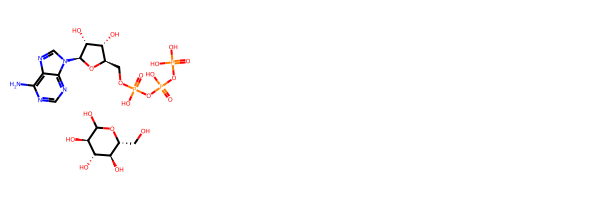

Predicting.. This will take a minute or so..

Prediction failed!


In [6]:
# prediction_type = "kcat" #@param ["kcat", "Km", "Ki"]
parameter = 'kcat' # @param ["kcat", "Km", "Ki"] {allow-input: true}
parameter = parameter.lower()

import os
import time
import pandas as pd
import numpy as np
from IPython.display import Image, display, Math
from rdkit import Chem
from rdkit.Chem.Draw.IPythonConsole import ShowMols

uniprot_id = "P35557" #@param {type:"string"}
#@markdown UNIPORT_ID 가 없는 경우 이름을 입력하세요. (예시: "enzyme1")
sequence = 'MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ' #@param {type:"string"}
SMILES = "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O.C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O)N " #@param {type:"string"}

# Main execution
seq, smi = create_csv_sh(parameter, uniprot_id, sequence, SMILES)

import subprocess

if seq and smi:
    print('예측 중............................\n')
    try:
        # 스크립트 실행
        command = (
            "source activate catpred && "
            "export PROTEIN_EMBED_USE_CPU=1 && "
            "chmod +x ./predict.sh && "
            "./predict.sh"
        )
        #상태 확인
        status = subprocess.call(command, shell=True, executable="/bin/bash")
        if status == 0:
            print('예측 성공!\n')
            get_predictions(parameter, uniprot_id)
        else:
            print('예측 실패.............ㅜㅜ')
    except Exception as e:
        print(f"에러 발생: {e} 건")

---
## BRENDA에서 일치하는 값 추출

In [ ]:
# BRENDA에서 찾기
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_brenda(brenda_df, input_smi, seq, parameter)

# 매치된 애들 출력
display_matches_brenda(matched_values, parameter)

Found 3 occurrences of input in BRENDA:


organism       ec  substrate        parameter  value   ph  \
32800  Homo sapiens  2.7.1.1  D-glucose  turnover_number   40.1  8.6   
32801  Homo sapiens  2.7.1.1  D-glucose  turnover_number   60.4  7.4   
32802  Homo sapiens  2.7.1.1  D-glucose  turnover_number   62.8  8.6   

       temperature                                            comment  \
32800         33.0                #87# wild-type, pH 7.6, 25 °C <240>   
32801         37.0  #87# wild type enzyme, in 25 mM HEPES (pH 7.4)...   
32802         33.0  #87# pH 7.1, temperature not specified in the ...   

                                         reaction_smiles  
32800  C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...  
32801  C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...  
32802  C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...

---
## SABIO-RK 일치하는 값 추출

In [ ]:
# SABIO_RK 에서 찾기
input_smi = preprocess_reaction_smiles(smi)
seq = seq
parameter = parameter
matched_values = find_matches_sabio(sabio_df, input_smi, seq, parameter)

# 매치된 애들 출력
display_matches_sabio(matched_values, parameter)

Found 15 occurrences of input in SABIO-RK:


species       ec            param_species_name param_name  \
25241  Homo sapiens  2.7.1.2                           NaN       kcat   
25250  Homo sapiens  2.7.1.2                           NaN       kcat   
25255  Homo sapiens  2.7.1.2        N-Acetyl-D-glucosamine       kcat   
25259  Homo sapiens  2.7.1.2  alpha-D-Mannoheptulopyranose       kcat   
25270  Homo sapiens  2.7.1.2                           ATP       kcat   
25272  Homo sapiens  2.7.1.2                           ATP       kcat   
25274  Homo sapiens  2.7.1.2                     D-Glucose       kcat   
25276  Homo sapiens  2.7.1.2                     D-Glucose       kcat   
25282  Homo sapiens  2.7.1.2                 D-Glucosamine       kcat   
25287  Homo sapiens  2.7.1.2                     D-Glucose       kcat   
25288  Homo sapiens  2.7.1.2                     D-Glucose       kcat   
25368  Homo sapiens  2.7.1.2                           ATP       kcat   
25369  Homo sapiens  2.7.1.2                           ATP       kcat   
25371  Homo sapiens  2.7.1.2                           ATP       kcat   
25372  Homo sapiens  2.7.1.2                           ATP       kcat   

       param_value   ph  temperature   pubmed_id  \
25241         66.4  7.5         30.0   7742312.0   
25250         56.4  7.5         30.0   7742312.0   
25255         66.4  7.5         30.0   7742312.0   
25259         66.4  7.5         30.0   7742312.0   
25270         62.3  7.4         30.0  15677479.0   
25272         62.3  7.4         30.0  15677479.0   
25274         66.7  NaN         30.0   7961659.0   
25276         56.0  7.5         30.0   7961659.0   
25282         66.4  NaN         30.0   7961659.0   
25287         66.4  NaN         30.0   7961659.0   
25288         66.7  NaN         30.0   7961659.0   
25368         18.0  8.0         25.0  16768451.0   
25369         38.0  8.0         25.0  16768451.0   
25371         38.0  8.0         25.0  16768451.0   
25372         18.0  8.0         25.0  16768451.0   

                                         reaction_smiles  
25241  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25250  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25255  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25259  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25270  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25272  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...  
25274  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25276  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25282  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...  
25287  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25288  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...  
25368  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25369  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...  
25371  OCC1OC(O)C(O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O...  
25372  Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...

---

# Helper Code

## 기질 SMILES 문자열 사용해서 반응 SMILES 문자열 Helper


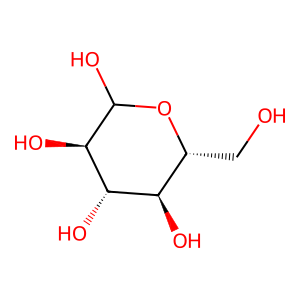
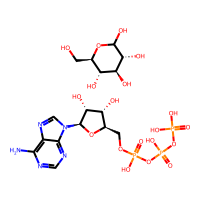

In [ ]:
#@markdown 효소 서열과 기질 SMILES을 입력으로 받아 효소 서열 및 기질 SMILES과 일치하는 BRENDA 및 SABIO-RK의 적중을 찾아 핵심 활성제를 나열합니다.
# prediction_type = "kcat" #@param ["kcat", "Km", "Ki"]
parameter = parameter.lower()

import time
import pandas as pd
import numpy as np
from IPython.display import Image, display
from rdkit import Chem
from rdkit.Chem.Draw.IPythonConsole import ShowMols

sequence = 'MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ' #@param {type:"string"}
Substrate_SMILES = "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O " #@param {type:"string"}

matched_seq = find_matches_brenda_seq(brenda_df, sequence)

from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, HTML

# 이미지 변환
def mol_to_img_str(mol, size=(200, 200)):
    img = Draw.MolToImage(mol, size=size)
    import io
    import base64
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

#테이블 만들기
def create_table_html(rows, headers):
    table_html = """
    <table style="border-collapse: collapse; width: 100%; margin-bottom: 20px;">
      <tr>
    """
    for header in headers:
        table_html += f'<th style="border: 1px solid black; padding: 8px; text-align: center;">{header}</th>'
    table_html += "</tr>"

    for row in rows:
        table_html += "<tr>"
        for cell in row:
            table_html += f'<td style="border: 1px solid black; padding: 8px; text-align: center;">{cell}</td>'
        table_html += "</tr>"

    table_html += "</table>"
    return table_html

# query 분자에 대해 smiles로 가정
query_smiles = Substrate_SMILES
query_mol = Chem.MolFromSmiles(query_smiles)
query_img_str = mol_to_img_str(query_mol, size=(300, 300))

# query table 생성
query_table = create_table_html([
    ["Query Molecule", "SMILES"],
    [f'<img src="data:image/png;base64,{query_img_str}" alt="Query Molecule">', query_smiles]
], ["", ""])

# 일치하는 반응 테이블 생성
list_of_matched_rxns = list(set(matched_seq.reaction_smiles))
matched_rows = []

for i, rxn in enumerate(list_of_matched_rxns):
    reactant_smi = rxn.split('>>')[0]
    mol = Chem.MolFromSmiles(reactant_smi)
    img_str = mol_to_img_str(mol)

    matched_rows.append([
        str(i+1),
        f'<img src="data:image/png;base64,{img_str}" alt="Molecule {i+1}">',
        reactant_smi
    ])

matched_table = create_table_html(matched_rows, ["Index", "Reactants", "Concatenated reactants SMILES"])

# 테이블 합치고 출력
full_html = f"""
<h2>Query Molecule</h2>
{query_table}
<h2>Matched Reactions</h2>
{matched_table}
"""

display(HTML(full_html))

